In [0]:
from torch import nn, optim
from torch.nn import functional as F
import torch
from torchvision import datasets, transforms
from torchvision.utils import save_image


class VAE_Vanilla(nn.Module):
  
  """
  Define the VAE_Vanilla class
  
  """

    def __init__(self,input_size = 784, mid_layer_size = 400, latent_size = 30,output_size=784):
        super().__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(input_size,mid_layer_size)  #input observed data
        self.mu = nn.Linear(mid_layer_size,latent_size)  # mean
        self.logvar = nn.Linear(mid_layer_size, latent_size) # variance
        self.fc2 = nn.Linear(latent_size, mid_layer_size) # sampled latent variables
        self.fc3 = nn.Linear(mid_layer_size,output_size) # reconstruction

    
    def encoder(self,X):
        o1 = F.relu(self.fc1(X))
        return self.mu(o1), self.logvar(o1)   # approximate the mean and logarisim of variance

    def reparameterize(self, mu,logvar):
        
        std = torch.exp(0.5*logvar)
        epsilon = torch.randn_like(std)
        return mu + epsilon * std

    def decoder(self,sampled_latent_z):
        o2 = F.relu(self.fc2(sampled_latent_z))
        return torch.sigmoid(self.fc3(o2))

    def forward(self, X):
        mu, logvar = self.encoder(X.view(-1,self.input_size)) # flatten the 2D input here
        sampled_latent_z = self.reparameterize(mu,logvar)
        return self.decoder(sampled_latent_z), mu, logvar
    
    def loss_function(self, input_X, output_X, mu,logvar):

        reconstruction_loss = - F.binary_cross_entropy(output_X, input_X.view(-1,self.input_size), reduction = 'sum')
        
        KL_divergence = 0.5 * torch.sum(1+logvar-mu.pow(2)-logvar.exp())
        
        return - (reconstruction_loss + KL_divergence) # we want to maximize "reconstruction_loss - KL_divergence"




In [0]:
# define device, model, optimizer, batch_size and import data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE_Vanilla().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
BATCH_SIZE= 32
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True,transform=transforms.ToTensor()),batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),batch_size=BATCH_SIZE, shuffle=True)


# Trainning function for each epoch, return the average trainning error
def VAE_Vanilla_train():
    model.train() # this is for dropout 
    train_loss = 0

    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_data, mu, logvar  = model(data)
        loss = model.loss_function(data,recon_data,mu,logvar)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    return train_loss / len(train_loader.dataset)
  

# Test function for each epoch, return the average test error    
def VAE_Vanilla_test():
    model.eval() # this is for dropout removal
    test_loss = 0
    with torch.no_grad(): # gradient calculation is not needed
        for data, _ in test_loader:
            data = data.to(device)
            recon_data, mu, logvar = model(data)
            test_loss += model.loss_function(data,recon_data,mu,logvar)

    return test_loss/ len(test_loader.dataset)

In [0]:
!mkdir results

In [23]:
for epoch in range(1, 50):
  average_train_loss_per_epoch = VAE_Vanilla_train()
  print('====> Epoch: {} Average Training loss: {:.4f}'.format(epoch, average_train_loss_per_epoch))

  average_test_loss_per_epoch = VAE_Vanilla_test()
  print('====> Average Test set loss: {:.4f}'.format(average_test_loss_per_epoch))

  with torch.no_grad():
    sample = torch.randn(4, 30).to(device)
    sample = model.decoder(sample).cpu()
    save_image(sample.view(4, 1, 28, 28),'./results/sample_' + str(epoch) + '.png')

====> Epoch: 1 Average Training loss: 139.1330
====> Average Test set loss: 116.7939
====> Epoch: 2 Average Training loss: 114.1602
====> Average Test set loss: 111.0507
====> Epoch: 3 Average Training loss: 110.4375
====> Average Test set loss: 108.7017
====> Epoch: 4 Average Training loss: 108.7540
====> Average Test set loss: 107.3010
====> Epoch: 5 Average Training loss: 107.8047
====> Average Test set loss: 106.6419
====> Epoch: 6 Average Training loss: 107.0847
====> Average Test set loss: 106.1839
====> Epoch: 7 Average Training loss: 106.6227
====> Average Test set loss: 105.8181
====> Epoch: 8 Average Training loss: 106.1932
====> Average Test set loss: 105.7761
====> Epoch: 9 Average Training loss: 105.8733
====> Average Test set loss: 105.4282
====> Epoch: 10 Average Training loss: 105.5985
====> Average Test set loss: 105.1616
====> Epoch: 11 Average Training loss: 105.3032
====> Average Test set loss: 104.6157
====> Epoch: 12 Average Training loss: 105.1106
====> Average T

In [25]:
!ls results

sample_10.png  sample_1.png   sample_29.png  sample_38.png  sample_47.png
sample_11.png  sample_20.png  sample_2.png   sample_39.png  sample_48.png
sample_12.png  sample_21.png  sample_30.png  sample_3.png   sample_49.png
sample_13.png  sample_22.png  sample_31.png  sample_40.png  sample_4.png
sample_14.png  sample_23.png  sample_32.png  sample_41.png  sample_5.png
sample_15.png  sample_24.png  sample_33.png  sample_42.png  sample_6.png
sample_16.png  sample_25.png  sample_34.png  sample_43.png  sample_7.png
sample_17.png  sample_26.png  sample_35.png  sample_44.png  sample_8.png
sample_18.png  sample_27.png  sample_36.png  sample_45.png  sample_9.png
sample_19.png  sample_28.png  sample_37.png  sample_46.png


Populating the interactive namespace from numpy and matplotlib


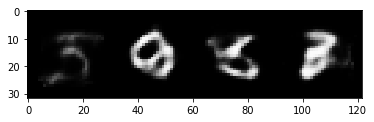

In [30]:
# plot the saved image file

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('results/sample_45.png')
imgplot = plt.imshow(img)
plt.show()